# 思路
![](https://ai-studio-static-online.cdn.bcebos.com/1df98d7a57354a5784cf9c5e60123cf8cd144a0df25543ffaa8303d7298893c5)

# 代码结构
### cell1：导入必要的库，并对数据进行初步处理。
### cell2：实例化模型以及网络，构建训练和评估函数，确定各项超参数。
### cell3：测试功能。
### 注：对应cell直接依次启动即可开始训练。

# 调优策略
### 根据acc和loss曲线重新选择优化算法，最终确定为Adam，再不断调试学习率。网络结构变更后对acc影响不大，所以保留了原有网络结构。同时根据验证集数据来看没有出现过过拟合现象，所以未采取正则化。

# 训练代码为cell2中train函数  
### 训练日志：[I 2022-07-04 13:37:39.966 SingleUserNotebookApp wsintercept:182] jupyter_notebook_cell: "class Classifier(paddle.nn.Layer):\n    # self\u4ee3\u8868\u7c7b\u7684\u5b9e\u4f8b\u81ea\u8eab\n    def __init__(self):\n        # \u521d\u59cb\u5316\u7236\u7c7b\u4e2d\u7684\u4e00\u4e9b\u53c2\u6570\n        super(Classifier, self).__init__()\n        \n        # \u7ebf\u6027\u53d8\u6362\u5c42\uff0c\u7531\u4e8e\u524d\u9762\u6570\u636e\u5206\u6790\u5904\u7406\u4e86id\uff0ctimecc\uff0cwin\uff0c\u6545\u8fd8\u526929\u4e2a\u53c2\u6570\u3002\n        self.fc1 = paddle.nn.Linear(in_features=29, out_features=40)\n        self.fc2 = paddle.nn.Linear(in_features=40, out_features=29)\n        self.fc3 = paddle.nn.Linear(in_features=29, out_features=1)          \n        self.relu = paddle.nn.ReLU()\n    \n    # \u7f51\u7edc\u7684\u524d\u5411\u8ba1\u7b97\n    def forward(self, inputs):\n        x = self.relu(self.fc1(inputs))\n        x = self.relu(self.fc2(x))\n        x = self.fc3(x)\n        return x\n\n# \u8bc4\u4f30\u51fd\u6570\u3002\ndef evaluation(model, epoch_id):\n    print('start evaluation...')\n    mini_batches_val = [val_data[k:k+BATCH_SIZE] for k in range(0, len(val_data), BATCH_SIZE)]\n    model.eval()\n\n    for batch_id, data in enumerate(mini_batches_val):\n        x = np.array(data[:, 1:]) # \u83b7\u5f97\u5f53\u524d\u6279\u6b21\u8bad\u7ec3\u6570\u636e\n        labels = np.array(data[:, :1]) # \u83b7\u5f97\u5f53\u524d\u6279\u6b21\u8bad\u7ec3\u6807\u7b7e\n        \n        features = paddle.to_tensor(x)\n        labels = paddle.to_tensor(labels)\n        \n        predicts_val = model(features)\n        loss = loss_fn(predicts_val, labels)\n        acc_val = (predicts_val > 0).astype(int).flatten() == labels.flatten().astype(int)\n        acc_val = acc_val.astype(float).mean()\n\n        avg_loss = paddle.mean(loss)\n        acc_val_set.append(float(acc_val.numpy()))\n        avg_loss_set.append(float(avg_loss.numpy()))\n    \n    #\u8ba1\u7b97\u591a\u4e2abatch\u7684\u5e73\u5747\u635f\u5931\u548c\u51c6\u786e\u7387\n    acc_val_mean = np.array(acc_val_set).mean()\n    avg_loss_val_mean = np.array(avg_loss_set).mean()\n    print('loss={}, acc={}'.format(avg_loss_val_mean, acc_val_mean))\n    \n    val_xlable.append(epoch_id)\n    val_ylable.append(acc_val_mean)\n\n# \u8bad\u7ec3\u51fd\u6570\u3002\ndef train():\n    # \u5b9a\u4e49\u5916\u5c42\u5faa\u73af\n    for epoch_id in range(EPOCH_NUM):\n        # \u5728\u6bcf\u8f6e\u8fed\u4ee3\u5f00\u59cb\u4e4b\u524d\uff0c\u5c06\u8bad\u7ec3\u6570\u636e\u7684\u987a\u5e8f\u968f\u673a\u7684\u6253\u4e71\n        np.random.shuffle(training_data)\n        # \u5c06\u8bad\u7ec3\u6570\u636e\u8fdb\u884c\u62c6\u5206\uff0c\u6bcf\u4e2abatch\u5305\u542b10\u6761\u6570\u636e\n        mini_batches = [training_data[k:k+BATCH_SIZE] for k in range(0, len(training_data), BATCH_SIZE)]\n        # \u5b9a\u4e49\u5185\u5c42\u5faa\u73af\n        for iter_id, mini_batch in enumerate(mini_batches):\n            x = np.array(mini_batch[:, 1:]) # \u83b7\u5f97\u5f53\u524d\u6279\u6b21\u8bad\u7ec3\u6570\u636e\n            y = np.array(mini_batch[:, :1]) # \u83b7\u5f97\u5f53\u524d\u6279\u6b21\u8bad\u7ec3\u6807\u7b7e \n            # \u5c06numpy\u6570\u636e\u8f6c\u4e3a\u98de\u6868\u52a8\u6001\u56fetensor\u7684\u683c\u5f0f\n            features = paddle.to_tensor(x)\n            y = paddle.to_tensor(y)\n            # \u524d\u5411\u8ba1\u7b97\n            predicts = model(features)\n            # \u8ba1\u7b97\u635f\u5931\n            loss = loss_fn(predicts, y, )\n            avg_loss = paddle.mean(loss)\n\n            if iter_id%400==0:\n                acc = (predicts > 0).astype(int).flatten() == y.flatten().astype(int)\n                acc = acc.astype(float).mean()\n                iters.append(iter_id + epoch_id*1600)\n                losses.append(avg_loss.numpy())\n                accs.append(acc.numpy())\n                print(\"epoch: {}, iter: {}, loss is: {}, acc is {}\".format(epoch_id, iter_id, avg_loss.numpy(), acc.numpy()))\n        \n            # \u53cd\u5411\u4f20\u64ad\uff0c\u8ba1\u7b97\u6bcf\u5c42\u53c2\u6570\u7684\u68af\u5ea6\u503c\n            avg_loss.backward()\n            # \u66f4\u65b0\u53c2\u6570\uff0c\u6839\u636e\u8bbe\u7f6e\u597d\u7684\u5b66\u4e60\u7387\u8fed\u4ee3\u4e00\u6b65\n            opt.step()\n            # \u6e05\u7a7a\u68af\u5ea6\u53d8\u91cf\uff0c\u4ee5\u5907\u4e0b\u4e00\u8f6e\u8ba1\u7b97\n            opt.clear_grad()\n            #scheduler.step(loss)\n        evaluation(model, epoch_id)\n        model.train\n\n\n'''Main\u4e3b\u8981\u903b\u8f91\u90e8\u5206'''\nmodel = Classifier()\nmodel.train()\nscheduler = paddle.optimizer.lr.ReduceOnPlateau(\n    learning_rate=0.001,\n    factor=0.5,\n    patience=3,\n    threshold=0.05)\nopt = paddle.optimizer.Adam(learning_rate=0.0009, parameters=model.parameters())# \u4f18\u5316\u5668\u91c7\u7528Adam\u7b97\u6cd5\nloss_fn = paddle.nn.BCEWithLogitsLoss()# \u9009\u62e9\u635f\u5931\u51fd\u6570\n\nEPOCH_NUM = 50   # \u8bbe\u7f6e\u5916\u5c42\u5faa\u73af\u6b21\u6570\nBATCH_SIZE = 100  # \u8bbe\u7f6ebatch\u5927\u5c0f\n# \u624b\u52a8\u5212\u5206\u4e86\u8bad\u7ec3\u96c6\u4e0e\u9a8c\u8bc1\u96c6\ntraining_data = train_df.iloc[:-20000,].values.astype(np.float32)\nval_data = train_df.iloc[-20000:, ].values.astype(np.float32)\n\n# \u4f5c\u56fe\u6240\u9700\u5217\u8868\niters = []\nlosses = []\naccs = []\nval_xlable = []\nval_ylable = []\nlearning_rate = []\nacc_val_set = []\navg_loss_set = []\n\ntrain()\n\n#\u8ba1\u7b97\u591a\u4e2abatch\u7684\u5e73\u5747\u635f\u5931\u548c\u51c6\u786e\u7387\nacc_train_mean = np.array(accs).mean()\navg_loss_train_mean = np.array(losses).mean()\nacc_val_mean = np.array(acc_val_set).mean()\navg_loss_val_mean = np.array(avg_loss_set).mean()\nprint('final_train:loss={}, acc={}'.format(avg_loss_train_mean, acc_train_mean))\nprint('final_val:loss={}, acc={}'.format(avg_loss_val_mean, acc_val_mean))\n\n# \u4f5c\u56fe,\u5305\u62ec\u8bad\u7ec3loss,acc\u548c\u9a8c\u8bc1acc\u3002\nplt.figure(1)\nplt.title(\"result\", fontsize=24)\nplt.xlabel(\"iter\", fontsize=14)\nplt.ylabel(\"loss and acc\", fontsize=14)\nplt.plot(iters, losses, color='red', label='train loss') \nplt.plot(iters, accs, color='blue', label='train acc')\nplt.grid()\nplt.figure(2)\nplt.plot(val_xlable, val_ylable, color='yellow', label='val acc') \nplt.grid()\nplt.show()\n\nmodelmodel=paddle.Model(model)\nmodelmodel.save('./save')"
# 评估代码为cell2中evaluation函数
### 测试日志：[I 2022-07-04 13:56:04.903 SingleUserNotebookApp wsintercept:182] jupyter_notebook_cell: "# \u6d4b\u8bd5\u3002\nmodel.eval()\ntest_data = paddle.to_tensor(test_df.values.astype(np.float32))\ntest_predict = model(test_data)\ntest_predict = (test_predict > 0).astype(int).flatten()\n\npd.DataFrame({'win':\n              test_predict.numpy()\n             }).to_csv('submission.csv', index=None)\n\n!zip submission.zip submission.csv"





In [1]:
import pandas as pd
import paddle
import numpy as np
%pylab inline
import seaborn as sns
import matplotlib.pyplot as plt

train_df = pd.read_csv('data/data137276/train.csv.zip')
test_df = pd.read_csv('data/data137276/test.csv.zip')

'''数据处理'''
# 删除id和timecc两列数据。
train_df = train_df.drop(['id', 'timecc'], axis=1)
test_df = test_df.drop(['id', 'timecc'], axis=1)
# 归一化处理数据。
for col in train_df.columns[1:]:
    train_df[col] /= train_df[col].max()
    test_df[col] /= test_df[col].max()

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/rcsetup.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:53: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sized


Populating the interactive namespace from numpy and matplotlib


## 搭建模型

W0704 13:53:39.264822  8516 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 11.2, Runtime API Version: 10.1
W0704 13:53:39.269140  8516 device_context.cc:465] device: 0, cuDNN Version: 7.6.


epoch: 0, iter: 0, loss is: [0.6921437], acc is [0.47]
epoch: 0, iter: 400, loss is: [0.400107], acc is [0.84]
epoch: 0, iter: 800, loss is: [0.36270475], acc is [0.86]
epoch: 0, iter: 1200, loss is: [0.43966103], acc is [0.78]
start evaluation...
loss=0.3609531340003014, acc=0.8363
epoch: 1, iter: 0, loss is: [0.40135607], acc is [0.86]
epoch: 1, iter: 400, loss is: [0.2955986], acc is [0.85]
epoch: 1, iter: 800, loss is: [0.26653063], acc is [0.88]
epoch: 1, iter: 1200, loss is: [0.38669243], acc is [0.8]
start evaluation...
loss=0.3547691867873073, acc=0.8389250000000001
epoch: 2, iter: 0, loss is: [0.39655772], acc is [0.81]
epoch: 2, iter: 400, loss is: [0.42615777], acc is [0.78]
epoch: 2, iter: 800, loss is: [0.4212108], acc is [0.75]
epoch: 2, iter: 1200, loss is: [0.32781637], acc is [0.85]
start evaluation...
loss=0.351827364663283, acc=0.83905
epoch: 3, iter: 0, loss is: [0.38158607], acc is [0.84]
epoch: 3, iter: 400, loss is: [0.3735374], acc is [0.82]
epoch: 3, iter: 800,

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


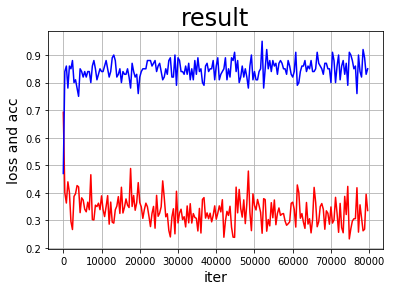

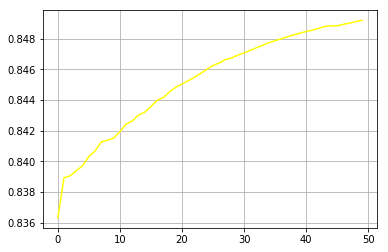

In [2]:
class Classifier(paddle.nn.Layer):
    # self代表类的实例自身
    def __init__(self):
        # 初始化父类中的一些参数
        super(Classifier, self).__init__()
        
        # 线性变换层，由于前面数据分析处理了id，timecc，win，故还剩29个参数。
        self.fc1 = paddle.nn.Linear(in_features=29, out_features=40)
        self.fc2 = paddle.nn.Linear(in_features=40, out_features=29)
        self.fc3 = paddle.nn.Linear(in_features=29, out_features=1)          
        self.relu = paddle.nn.ReLU()
    
    # 网络的前向计算
    def forward(self, inputs):
        x = self.relu(self.fc1(inputs))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# 评估函数。
def evaluation(model, epoch_id):
    print('start evaluation...')
    mini_batches_val = [val_data[k:k+BATCH_SIZE] for k in range(0, len(val_data), BATCH_SIZE)]
    model.eval()

    for batch_id, data in enumerate(mini_batches_val):
        x = np.array(data[:, 1:]) # 获得当前批次训练数据
        labels = np.array(data[:, :1]) # 获得当前批次训练标签
        
        features = paddle.to_tensor(x)
        labels = paddle.to_tensor(labels)
        
        predicts_val = model(features)
        loss = loss_fn(predicts_val, labels)
        acc_val = (predicts_val > 0).astype(int).flatten() == labels.flatten().astype(int)
        acc_val = acc_val.astype(float).mean()

        avg_loss = paddle.mean(loss)
        acc_val_set.append(float(acc_val.numpy()))
        avg_loss_set.append(float(avg_loss.numpy()))
    
    #计算多个batch的平均损失和准确率
    acc_val_mean = np.array(acc_val_set).mean()
    avg_loss_val_mean = np.array(avg_loss_set).mean()
    print('loss={}, acc={}'.format(avg_loss_val_mean, acc_val_mean))
    
    val_xlable.append(epoch_id)
    val_ylable.append(acc_val_mean)

# 训练函数。
def train():
    # 定义外层循环
    for epoch_id in range(EPOCH_NUM):
        # 在每轮迭代开始之前，将训练数据的顺序随机的打乱
        np.random.shuffle(training_data)
        # 将训练数据进行拆分，每个batch包含10条数据
        mini_batches = [training_data[k:k+BATCH_SIZE] for k in range(0, len(training_data), BATCH_SIZE)]
        # 定义内层循环
        for iter_id, mini_batch in enumerate(mini_batches):
            x = np.array(mini_batch[:, 1:]) # 获得当前批次训练数据
            y = np.array(mini_batch[:, :1]) # 获得当前批次训练标签 
            # 将numpy数据转为飞桨动态图tensor的格式
            features = paddle.to_tensor(x)
            y = paddle.to_tensor(y)
            # 前向计算
            predicts = model(features)
            # 计算损失
            loss = loss_fn(predicts, y, )
            avg_loss = paddle.mean(loss)

            if iter_id%400==0:
                acc = (predicts > 0).astype(int).flatten() == y.flatten().astype(int)
                acc = acc.astype(float).mean()
                iters.append(iter_id + epoch_id*1600)
                losses.append(avg_loss.numpy())
                accs.append(acc.numpy())
                print("epoch: {}, iter: {}, loss is: {}, acc is {}".format(epoch_id, iter_id, avg_loss.numpy(), acc.numpy()))
        
            # 反向传播，计算每层参数的梯度值
            avg_loss.backward()
            # 更新参数，根据设置好的学习率迭代一步
            opt.step()
            # 清空梯度变量，以备下一轮计算
            opt.clear_grad()
            #scheduler.step(loss)
        evaluation(model, epoch_id)
        model.train


'''Main主要逻辑部分'''
model = Classifier()
model.train()
scheduler = paddle.optimizer.lr.ReduceOnPlateau(
    learning_rate=0.001,
    factor=0.5,
    patience=3,
    threshold=0.05)
opt = paddle.optimizer.Adam(learning_rate=0.0009, parameters=model.parameters())# 优化器采用Adam算法
loss_fn = paddle.nn.BCEWithLogitsLoss()# 选择损失函数

EPOCH_NUM = 100   # 设置外层循环次数
BATCH_SIZE = 100  # 设置batch大小
# 手动划分了训练集与验证集
training_data = train_df.iloc[:-20000,].values.astype(np.float32)
val_data = train_df.iloc[-20000:, ].values.astype(np.float32)

# 作图所需列表
iters = []
losses = []
accs = []
val_xlable = []
val_ylable = []
learning_rate = []
acc_val_set = []
avg_loss_set = []

train()

#计算多个batch的平均损失和准确率
acc_train_mean = np.array(accs).mean()
avg_loss_train_mean = np.array(losses).mean()
acc_val_mean = np.array(acc_val_set).mean()
avg_loss_val_mean = np.array(avg_loss_set).mean()
print('final_train:loss={}, acc={}'.format(avg_loss_train_mean, acc_train_mean))
print('final_val:loss={}, acc={}'.format(avg_loss_val_mean, acc_val_mean))

# 作图,包括训练loss,acc和验证acc。
plt.figure(1)
plt.title("result", fontsize=24)
plt.xlabel("iter", fontsize=14)
plt.ylabel("loss and acc", fontsize=14)
plt.plot(iters, losses, color='red', label='train loss') 
plt.plot(iters, accs, color='blue', label='train acc')
plt.grid()
plt.figure(2)
plt.plot(val_xlable, val_ylable, color='yellow', label='val acc') 
plt.grid()
plt.show()

modelmodel=paddle.Model(model)
modelmodel.save('./save')

In [3]:
# 测试。
model.eval()
test_data = paddle.to_tensor(test_df.values.astype(np.float32))
test_predict = model(test_data)
test_predict = (test_predict > 0).astype(int).flatten()

pd.DataFrame({'win':
              test_predict.numpy()
             }).to_csv('submission.csv', index=None)

!zip submission.zip submission.csv

  adding: submission.csv (deflated 90%)
